In [13]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn
!pip install torchsampler

torch version: 1.13.1
torchvision version: 0.14.1
time: 10.5 s (started: 2023-05-12 17:07:26 +00:00)


In [14]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.49 s (started: 2023-05-12 17:07:36 +00:00)


In [ ]:
#unzip the data that we had split earlier before in the preprocessing data notebook, to ensure that the same split data was used for every model
!unzip /isic2019-dataset.zip

In [7]:
from torchvision.transforms import Compose, CenterCrop, Normalize, Resize, ToTensor
from torchvision.transforms import InterpolationMode
from torchvision.transforms import RandAugment

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the transformation parameters, that will be used to pre-process the data in the imagefolder function from Pytorch 
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC), #resize the image to 224 by 224
    transforms.CenterCrop(size=224), # apply centercrop
    transforms.ToTensor(), #converts the image from a PIL Image object to a PyTorch tensor.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #normalizes the tensor image
])

time: 2.14 ms (started: 2023-05-07 12:36:29 +00:00)


Hyperparameter tuning: We used optuna hyperparameter optimization framework and defined the train and validation set and the Repvgg model within this function. The validation set was used to tune the hyperparameters. 

In [8]:
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import optuna
import timm
import torch.utils.data.sampler as sampler
from torch.utils.data import Subset
from torch.utils.data.sampler import RandomSampler
import torchvision.datasets as datasets
from sklearn import metrics
from sklearn.metrics import f1_score
from torchsampler import ImbalancedDatasetSampler

# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

#define hyperparameter tuning, furthermore we will use 
#10 trials to look for the best hyperparameters. We re-used the optuna hyperparamete optimization code 
#the code that was re-used is available at: https://github.com/optuna/optuna

# Define the dataset and dataloader
def get_data_loaders(batch_size):

# Load and transform the data

    # Load the datasets
    train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
    val_dataset = datasets.ImageFolder(root='data/valid', transform=transform)

    # load the data and shuffle the training data, we apply random oversampling and undersampling in the sampler argument and only for the training set. 
    train_dataloader = data.DataLoader(train_dataset, batch_size=32, sampler=ImbalancedDatasetSampler(train_dataset),pin_memory=True, num_workers=4)
    valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    return train_dataloader, valid_dataloader

def get_model(trial, dropout, num_hidden_layers, num_neurons):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = 'repvgg_b3'
    model = timm.create_model(model_name, pretrained=True, num_classes=8)
    
    num_in_features = model.get_classifier().in_features

    # Define the classification head with the number of neurons and hidden layers to optimize
    classifier_layers = []
    for i in range(num_hidden_layers):
        if i == 0:
            in_features = num_in_features
            out_features = num_neurons
        else:
            in_features = num_neurons
            out_features = num_neurons
        classifier_layers.extend([
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Dropout(p=dropout),
        ])
    classifier_layers.append(nn.Linear(num_neurons, 8))
    model.head.fc = nn.Sequential(*classifier_layers)

    # Freeze the weights
    for param in model.parameters():
        param.requires_grad = False
   
    # Unfreeze the classifierhead layer 
    for param in model.head.parameters():
        param.requires_grad = True

    return model

# Define the objective function for Optuna
def objective(trial):
    # Get the hyperparameters to optimize
    batch_size = 32  # set batch size to 32
    epochs = 20  # set epochs to 20
    num_epochs = 20
    optimizer_name = trial.suggest_categorical("optimizer_name", ["AdamW", "SGD"])
    weight_decay = trial.suggest_float("weight_decay", low=0.001, high=0.01, log=True)
    learning_rate = trial.suggest_float("learning_rate", low=0.001, high=0.01, log=True)
    dropout = trial.suggest_categorical("dropout", [0.25,0.5])
    num_hidden_layers = trial.suggest_int("num_hidden_layers", low=1, high=2)
    num_neurons = trial.suggest_categorical("num_neurons", [256, 512])

    # Get the data loaders
    train_dataloader, valid_dataloader = get_data_loaders(batch_size)

    # Get the model
    model = get_model(trial, dropout, num_hidden_layers, num_neurons)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Define the optimizer and loss function
    if optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    else:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

# Initialize variables for early stopping
    best_accuracy = 0.0
    best_val_loss = float('inf')
    best_f1_score = 0.0
    patience = 3
    no_improvement_count = 0

   # Train the model
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        running_total = 0
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                scaler.scale(loss).backward()    # Scale the gradients
                scaler.step(optimizer)           # Update the model parameters
                scaler.update()                  # Update the scaler

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_corrects += (predicted == labels).sum().item()

        # Calculate the training loss and training accuracy
        train_loss = running_loss / len(train_dataloader.dataset)
        train_accuracy = 100 * running_corrects / running_total

        # evaluate on the validation set
        correct = 0
        total = 0
        val_loss = 0.0
        y_true, y_pred = [], []
        model.eval()
        with torch.no_grad():
            for data in valid_dataloader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item() * labels.size(0)

                y_true += labels.cpu().tolist()
                y_pred += predicted.cpu().tolist()

        # Calculate the validation accuracy and validation loss
        accuracy = 100 * correct / total
        val_loss /= len(valid_dataloader.dataset)

        #calculate the macro f1-score
        f1_score = metrics.f1_score(y_true, y_pred, average='macro')

        # Print the accuracy, validation loss, and f1-score
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_accuracy:.2f}%, Validation Loss = {val_loss:.4f}, Validation Accuracy = {accuracy:.2f}%, F1-score = {f1_score:.4f}")

        # Report the intermediate result
        trial.report(f1_score, epoch)

        # Check if the validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        # Check if the f1 score has improved
        if f1_score > best_f1_score:
            best_f1_score = f1_score

        # Check if early stopping criteria has been met
        if no_improvement_count >= patience:
            print(f"No improvement after {no_improvement_count} epochs. Stopping training...")
            break

    return best_f1_score

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-05-07 12:36:30,254] A new study created in memory with name: no-name-27fede28-0e9f-4949-a750-3b1742a6c542


Epoch 1: Train Loss = 1.1820, Train Accuracy = 58.48%, Validation Loss = 1.1954, Validation Accuracy = 56.72%, F1-score = 0.4213
Epoch 2: Train Loss = 0.7701, Train Accuracy = 72.66%, Validation Loss = 1.0796, Validation Accuracy = 61.12%, F1-score = 0.4543
Epoch 3: Train Loss = 0.6720, Train Accuracy = 75.73%, Validation Loss = 1.2205, Validation Accuracy = 57.27%, F1-score = 0.4645
Epoch 4: Train Loss = 0.6271, Train Accuracy = 77.66%, Validation Loss = 1.1188, Validation Accuracy = 60.05%, F1-score = 0.4560


[I 2023-05-07 12:47:42,696] Trial 0 finished with value: 0.46447082574704945 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.004014513244488423, 'learning_rate': 0.0010107732892015993, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 0 with value: 0.46447082574704945.


Epoch 5: Train Loss = 0.5718, Train Accuracy = 79.40%, Validation Loss = 1.3261, Validation Accuracy = 57.27%, F1-score = 0.4279
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3209, Train Accuracy = 52.67%, Validation Loss = 1.0885, Validation Accuracy = 58.72%, F1-score = 0.4261
Epoch 2: Train Loss = 0.7892, Train Accuracy = 71.69%, Validation Loss = 0.9903, Validation Accuracy = 65.95%, F1-score = 0.4625
Epoch 3: Train Loss = 0.6777, Train Accuracy = 75.81%, Validation Loss = 1.0611, Validation Accuracy = 61.63%, F1-score = 0.4648
Epoch 4: Train Loss = 0.6158, Train Accuracy = 77.91%, Validation Loss = 1.5621, Validation Accuracy = 46.50%, F1-score = 0.3810


[I 2023-05-07 12:58:51,135] Trial 1 finished with value: 0.4747156643218458 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0019812441899523807, 'learning_rate': 0.004389095574583234, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 1 with value: 0.4747156643218458.


Epoch 5: Train Loss = 0.5731, Train Accuracy = 79.47%, Validation Loss = 1.1285, Validation Accuracy = 63.12%, F1-score = 0.4747
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2387, Train Accuracy = 55.49%, Validation Loss = 1.1041, Validation Accuracy = 57.86%, F1-score = 0.4283
Epoch 2: Train Loss = 0.7785, Train Accuracy = 71.96%, Validation Loss = 1.1809, Validation Accuracy = 57.03%, F1-score = 0.4809
Epoch 3: Train Loss = 0.6601, Train Accuracy = 76.46%, Validation Loss = 1.1170, Validation Accuracy = 61.04%, F1-score = 0.4741


[I 2023-05-07 13:07:47,635] Trial 2 finished with value: 0.4809259593245181 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.003339276396099544, 'learning_rate': 0.004218785310428087, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 256}. Best is trial 2 with value: 0.4809259593245181.


Epoch 4: Train Loss = 0.5960, Train Accuracy = 78.72%, Validation Loss = 1.3444, Validation Accuracy = 56.83%, F1-score = 0.4205
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.3561, Train Accuracy = 53.94%, Validation Loss = 1.2502, Validation Accuracy = 55.11%, F1-score = 0.4018
Epoch 2: Train Loss = 0.7768, Train Accuracy = 72.60%, Validation Loss = 1.0408, Validation Accuracy = 60.72%, F1-score = 0.4549
Epoch 3: Train Loss = 0.6602, Train Accuracy = 77.19%, Validation Loss = 1.1724, Validation Accuracy = 54.44%, F1-score = 0.4570
Epoch 4: Train Loss = 0.6317, Train Accuracy = 78.64%, Validation Loss = 0.9843, Validation Accuracy = 62.18%, F1-score = 0.4678
Epoch 5: Train Loss = 0.6208, Train Accuracy = 78.97%, Validation Loss = 1.0466, Validation Accuracy = 60.84%, F1-score = 0.4806
Epoch 6: Train Loss = 0.6107, Train Accuracy = 79.75%, Validation Loss = 1.0446, Validation Accuracy = 60.17%, F1-score = 0.4776


[I 2023-05-07 13:23:35,494] Trial 3 finished with value: 0.480579152236689 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.00594133093657162, 'learning_rate': 0.007273786280064513, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 2 with value: 0.4809259593245181.


Epoch 7: Train Loss = 0.5928, Train Accuracy = 80.07%, Validation Loss = 1.0138, Validation Accuracy = 62.84%, F1-score = 0.4803
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1805, Train Accuracy = 57.89%, Validation Loss = 1.1936, Validation Accuracy = 56.91%, F1-score = 0.4252
Epoch 2: Train Loss = 0.7416, Train Accuracy = 73.91%, Validation Loss = 1.1212, Validation Accuracy = 57.23%, F1-score = 0.4599
Epoch 3: Train Loss = 0.6371, Train Accuracy = 77.61%, Validation Loss = 1.0676, Validation Accuracy = 61.04%, F1-score = 0.4774
Epoch 4: Train Loss = 0.5575, Train Accuracy = 80.47%, Validation Loss = 1.0469, Validation Accuracy = 62.65%, F1-score = 0.4824
Epoch 5: Train Loss = 0.5378, Train Accuracy = 81.40%, Validation Loss = 1.0234, Validation Accuracy = 61.98%, F1-score = 0.4834
Epoch 6: Train Loss = 0.5239, Train Accuracy = 81.63%, Validation Loss = 1.0031, Validation Accuracy = 63.51%, F1-score = 0.5188
Epoch 7: Train Loss = 0.5068, Train Accuracy 

[I 2023-05-07 13:52:40,636] Trial 4 finished with value: 0.5232085578627033 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.008591581674483866, 'learning_rate': 0.001821087794328444, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 4 with value: 0.5232085578627033.


Epoch 13: Train Loss = 0.4705, Train Accuracy = 84.28%, Validation Loss = 0.9935, Validation Accuracy = 63.79%, F1-score = 0.5232
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2367, Train Accuracy = 57.06%, Validation Loss = 1.3275, Validation Accuracy = 49.96%, F1-score = 0.3960
Epoch 2: Train Loss = 0.7742, Train Accuracy = 72.21%, Validation Loss = 1.0221, Validation Accuracy = 63.94%, F1-score = 0.4744
Epoch 3: Train Loss = 0.6453, Train Accuracy = 76.81%, Validation Loss = 1.1460, Validation Accuracy = 58.88%, F1-score = 0.4495
Epoch 4: Train Loss = 0.5945, Train Accuracy = 78.60%, Validation Loss = 1.2356, Validation Accuracy = 56.52%, F1-score = 0.4384


[I 2023-05-07 14:04:02,744] Trial 5 finished with value: 0.47440151808364656 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.0016354915773984376, 'learning_rate': 0.004713992541388685, 'dropout': 0.25, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 4 with value: 0.5232085578627033.


Epoch 5: Train Loss = 0.5625, Train Accuracy = 79.76%, Validation Loss = 1.3161, Validation Accuracy = 52.63%, F1-score = 0.4512
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.1890, Train Accuracy = 57.31%, Validation Loss = 1.1893, Validation Accuracy = 57.31%, F1-score = 0.4040
Epoch 2: Train Loss = 0.7936, Train Accuracy = 71.73%, Validation Loss = 1.2125, Validation Accuracy = 57.11%, F1-score = 0.4392
Epoch 3: Train Loss = 0.6661, Train Accuracy = 76.11%, Validation Loss = 1.2130, Validation Accuracy = 59.47%, F1-score = 0.4346
Epoch 4: Train Loss = 0.6108, Train Accuracy = 78.17%, Validation Loss = 1.1723, Validation Accuracy = 61.35%, F1-score = 0.4681
Epoch 5: Train Loss = 0.5598, Train Accuracy = 79.86%, Validation Loss = 1.3402, Validation Accuracy = 54.12%, F1-score = 0.4470
Epoch 6: Train Loss = 0.5290, Train Accuracy = 80.97%, Validation Loss = 1.2140, Validation Accuracy = 60.29%, F1-score = 0.4782


[I 2023-05-07 14:19:52,790] Trial 6 finished with value: 0.47817744710252225 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.006272135527076135, 'learning_rate': 0.003184188208119094, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 4 with value: 0.5232085578627033.


Epoch 7: Train Loss = 0.5006, Train Accuracy = 82.11%, Validation Loss = 1.4084, Validation Accuracy = 55.34%, F1-score = 0.4453
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2022, Train Accuracy = 57.21%, Validation Loss = 1.1235, Validation Accuracy = 57.31%, F1-score = 0.4337
Epoch 2: Train Loss = 0.7415, Train Accuracy = 73.62%, Validation Loss = 1.0208, Validation Accuracy = 63.35%, F1-score = 0.4698
Epoch 3: Train Loss = 0.6310, Train Accuracy = 77.24%, Validation Loss = 1.1090, Validation Accuracy = 61.94%, F1-score = 0.4759
Epoch 4: Train Loss = 0.5637, Train Accuracy = 80.31%, Validation Loss = 1.0615, Validation Accuracy = 61.98%, F1-score = 0.4969


[I 2023-05-07 14:32:38,696] Trial 7 finished with value: 0.4968516502207527 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0032234737587625807, 'learning_rate': 0.006420631546057046, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}. Best is trial 4 with value: 0.5232085578627033.


Epoch 5: Train Loss = 0.5379, Train Accuracy = 81.11%, Validation Loss = 1.1531, Validation Accuracy = 58.60%, F1-score = 0.4701
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2826, Train Accuracy = 55.29%, Validation Loss = 1.2360, Validation Accuracy = 55.85%, F1-score = 0.4060
Epoch 2: Train Loss = 0.7706, Train Accuracy = 72.75%, Validation Loss = 1.0805, Validation Accuracy = 59.98%, F1-score = 0.4619
Epoch 3: Train Loss = 0.6272, Train Accuracy = 77.39%, Validation Loss = 1.0459, Validation Accuracy = 63.79%, F1-score = 0.4656
Epoch 4: Train Loss = 0.5598, Train Accuracy = 80.18%, Validation Loss = 1.1394, Validation Accuracy = 61.23%, F1-score = 0.4690
Epoch 5: Train Loss = 0.5089, Train Accuracy = 81.53%, Validation Loss = 1.0416, Validation Accuracy = 63.98%, F1-score = 0.5003
Epoch 6: Train Loss = 0.4772, Train Accuracy = 82.79%, Validation Loss = 1.1353, Validation Accuracy = 60.33%, F1-score = 0.4899
Epoch 7: Train Loss = 0.4542, Train Accuracy 

[I 2023-05-07 14:54:14,056] Trial 8 finished with value: 0.500254763544233 and parameters: {'optimizer_name': 'SGD', 'weight_decay': 0.0015371598493631366, 'learning_rate': 0.0041176307616016, 'dropout': 0.5, 'num_hidden_layers': 1, 'num_neurons': 512}. Best is trial 4 with value: 0.5232085578627033.


Epoch 8: Train Loss = 0.4348, Train Accuracy = 84.30%, Validation Loss = 1.2218, Validation Accuracy = 58.05%, F1-score = 0.4754
No improvement after 3 epochs. Stopping training...
Epoch 1: Train Loss = 1.2897, Train Accuracy = 54.43%, Validation Loss = 1.1995, Validation Accuracy = 55.46%, F1-score = 0.4037
Epoch 2: Train Loss = 0.8079, Train Accuracy = 71.12%, Validation Loss = 1.4267, Validation Accuracy = 52.99%, F1-score = 0.4118
Epoch 3: Train Loss = 0.6786, Train Accuracy = 75.50%, Validation Loss = 1.1362, Validation Accuracy = 62.06%, F1-score = 0.4521
Epoch 4: Train Loss = 0.6234, Train Accuracy = 77.42%, Validation Loss = 1.1478, Validation Accuracy = 60.96%, F1-score = 0.4725
Epoch 5: Train Loss = 0.5793, Train Accuracy = 79.15%, Validation Loss = 1.1878, Validation Accuracy = 62.02%, F1-score = 0.4610
Epoch 6: Train Loss = 0.5518, Train Accuracy = 80.04%, Validation Loss = 1.1186, Validation Accuracy = 62.22%, F1-score = 0.4479
Epoch 7: Train Loss = 0.5188, Train Accuracy 

[I 2023-05-07 15:18:25,241] Trial 9 finished with value: 0.47312174551888025 and parameters: {'optimizer_name': 'AdamW', 'weight_decay': 0.003646538733683145, 'learning_rate': 0.0020081721555041867, 'dropout': 0.5, 'num_hidden_layers': 2, 'num_neurons': 512}. Best is trial 4 with value: 0.5232085578627033.


Epoch 9: Train Loss = 0.4695, Train Accuracy = 83.22%, Validation Loss = 1.2483, Validation Accuracy = 61.23%, F1-score = 0.4731
No improvement after 3 epochs. Stopping training...
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  10
Best trial:
  Value:  0.5232085578627033
  Params: 
    optimizer_name: SGD
    weight_decay: 0.008591581674483866
    learning_rate: 0.001821087794328444
    dropout: 0.25
    num_hidden_layers: 2
    num_neurons: 256
time: 2h 41min 55s (started: 2023-05-07 12:36:29 +00:00)


/tmp/ipykernel_479/3515757420.py:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

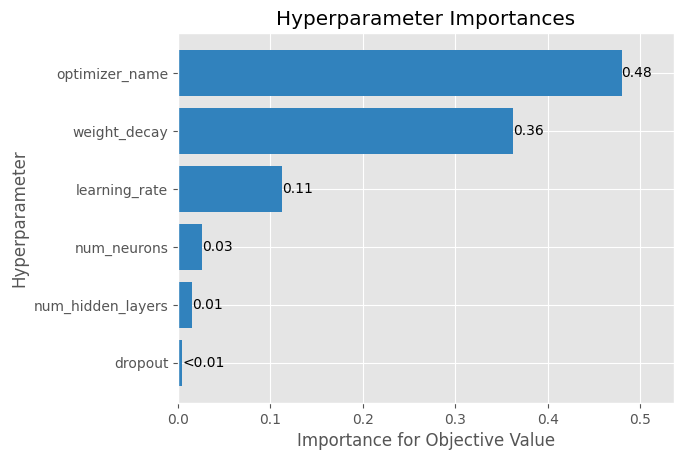

time: 441 ms (started: 2023-05-07 15:18:25 +00:00)


In [9]:
#shows the importance of each hyperparameter
fig = optuna.visualization.matplotlib.plot_param_importances(study)
fig

In [10]:
# Retrieve the best set of hyperparameters
best_params = study.best_params
print(best_params)

{'optimizer_name': 'SGD', 'weight_decay': 0.008591581674483866, 'learning_rate': 0.001821087794328444, 'dropout': 0.25, 'num_hidden_layers': 2, 'num_neurons': 256}
time: 885 µs (started: 2023-05-07 15:31:07 +00:00)


Concatenate the training and validation dataset into one final training set 

In [ ]:
import os
import shutil

# Set the random seed for reproducibility
torch.manual_seed(42)

#this code combines both train and validation dataset into one training set, so we can use this to train the model on a larger dataset. 
train_dir = '/data/train'
val_dir = '/data/valid'

# Loop through the subdirectories in val_dir and move their files to train_dir
for class_dir in os.listdir(val_dir):
    src_class_dir = os.path.join(val_dir, class_dir)
    dst_class_dir = os.path.join(train_dir, class_dir)
        
    # Create the destination directory if it doesn't exist yet
    if not os.path.exists(dst_class_dir):
        os.makedirs(dst_class_dir)
        
    # Loop through the files in the source directory and move them to the destination directory
    for file in os.listdir(src_class_dir):
        src_file = os.path.join(src_class_dir, file)
        dst_file = os.path.join(dst_class_dir, file)
        shutil.move(src_file, dst_file)

# Remove the val_dir if it is empty
if not os.listdir(val_dir):
    os.rmdir(val_dir)

In [4]:
import timm 
#look up all the repvgg models in timm's library
repvgg_models = timm.list_models('*repvgg*')
repvgg_models

['repvgg_a2',
 'repvgg_b0',
 'repvgg_b1',
 'repvgg_b1g4',
 'repvgg_b2',
 'repvgg_b2g4',
 'repvgg_b3',
 'repvgg_b3g4']

time: 287 ms (started: 2023-05-12 15:50:16 +00:00)


Use the imagefolder and dataloader function from Pytorch to preprocess and load the data to re-train the model on the final training set and evaluate on the test set, using the best obtained hyperparameter values during Hyperparameter tuning 

In [16]:
#The code that is re-used to apply random oversampling and undersampling on the training set is available at: https://github.com/ufoym/imbalanced-dataset-sampler

# loading and transforming the data
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset
from torchsampler import ImbalancedDatasetSampler

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)

# load the data and shuffle the training data, we apply random oversampling and undersampling in the sampler argument and only for the training set. 
train_dataloader = data.DataLoader(train_dataset, batch_size=32, sampler=ImbalancedDatasetSampler(train_dataset),pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

time: 73.4 ms (started: 2023-05-12 17:07:43 +00:00)


Create the repvgg_b3 model from Timm's library

In [ ]:
#create the repvgg model
#The deep learning library called Timm was used to create the pre-trained models which has the weights pre-loaded. 
#A link to the github library is available at: https://github.com/huggingface/pytorch-image-models
#create model with new variable name and the best HP values to re-train the model 

import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
new_model = timm.create_model('repvgg_b3', pretrained=True, num_classes=8)

num_in_features = new_model.get_classifier().in_features

# Define the classification head with the best hyperparameter values
num_hidden_layers = 2
num_neurons = 256
dropout = 0.25
classifier_layers = []
for i in range(num_hidden_layers):
    if i == 0:
        in_features = num_in_features
        out_features = num_neurons
    else:
        in_features = num_neurons
        out_features = num_neurons
    classifier_layers.extend([
        nn.Linear(in_features, out_features),
        nn.BatchNorm1d(out_features),
        nn.Dropout(p=dropout),
    ])
classifier_layers.append(nn.Linear(num_neurons, 8))
new_model.head.fc = nn.Sequential(*classifier_layers)

#freeze the weights
for param in new_model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in new_model.head.parameters():
    param.requires_grad = True


new_model.to(device)

In [18]:
# Print a summary using torchinfo (uncomment for actual output)

summary(model=new_model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
ByobNet (ByobNet)                                  [32, 3, 224, 224]    [32, 8]              --                   Partial
├─RepVggBlock (stem)                               [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─ConvNormAct (conv_1x1)                      [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    │    └─Conv2d (conv)                          [32, 3, 224, 224]    [32, 64, 112, 112]   (192)                False
│    │    └─BatchNormAct2d (bn)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ConvNormAct (conv_kxk)                      [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    │    └─Conv2d (conv)                          [32, 3, 224, 224]    [32, 64, 112, 112]   (1,728)              False
│    │    └─BatchNormAct2d (bn)   

time: 97.5 ms (started: 2023-05-12 17:07:49 +00:00)


In [19]:
# define optimizers and loss function and use the best hyperparameters found during hyperparameter tuning
import torch.optim as optim

# Set the random seed for reproducibility
torch.manual_seed(42)

# define optimizers and loss function. 

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(new_model.parameters(), lr=0.001821087794328444, momentum=0.9, nesterov=True, weight_decay = 0.008591581674483866)

time: 3.43 ms (started: 2023-05-12 17:07:50 +00:00)


In [20]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
test_losses = []
test_accs = []

# Initialize variables for early stopping
best_test_loss = float('inf')
no_improvement_count = 0
epochs = 13
num_epochs = 13

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()    # Scale the gradients
            scaler.step(optimizer)           # Update the model parameters
            scaler.update()                  # Update the scaler

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        running_total += labels.size(0)
        running_corrects += (predicted == labels).sum().item()

    # Calculate the training loss and training accuracy
    train_loss = running_loss / len(train_dataloader.dataset)
    train_accuracy = 100 * running_corrects / running_total

    # evaluate on the test set
    new_model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    y_true = []
    y_scores = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = new_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item() * labels.size(0)

            # collect the predictions for the metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    # Calculate the test accuracy and test loss
    test_accuracy = 100 * correct / total
    test_loss /= len(test_dataloader.dataset)
  
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")
            
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

Epoch 1/13: Train Loss: 1.1715, Train Acc: 58.0550, Test Loss: 1.2736, Test Acc: 53.9140
Epoch 2/13: Train Loss: 0.7500, Train Acc: 73.5490, Test Loss: 1.1738, Test Acc: 55.5257
Epoch 3/13: Train Loss: 0.6332, Train Acc: 77.5886, Test Loss: 1.3004, Test Acc: 51.3047
Epoch 4/13: Train Loss: 0.5957, Train Acc: 78.9043, Test Loss: 1.0420, Test Acc: 62.6631
Epoch 5/13: Train Loss: 0.5475, Train Acc: 81.0385, Test Loss: 1.0428, Test Acc: 63.6992
Epoch 6/13: Train Loss: 0.5377, Train Acc: 81.5226, Test Loss: 1.0540, Test Acc: 61.6270
Epoch 7/13: Train Loss: 0.5190, Train Acc: 82.1122, Test Loss: 1.1882, Test Acc: 56.2932
Epoch 8/13: Train Loss: 0.5132, Train Acc: 82.5083, Test Loss: 1.0484, Test Acc: 62.1642
Epoch 9/13: Train Loss: 0.5051, Train Acc: 82.7943, Test Loss: 1.0738, Test Acc: 60.6677
Epoch 10/13: Train Loss: 0.4968, Train Acc: 83.0407, Test Loss: 1.0428, Test Acc: 62.6247
Epoch 11/13: Train Loss: 0.4974, Train Acc: 83.2739, Test Loss: 1.0777, Test Acc: 62.5863
Epoch 12/13: Train 

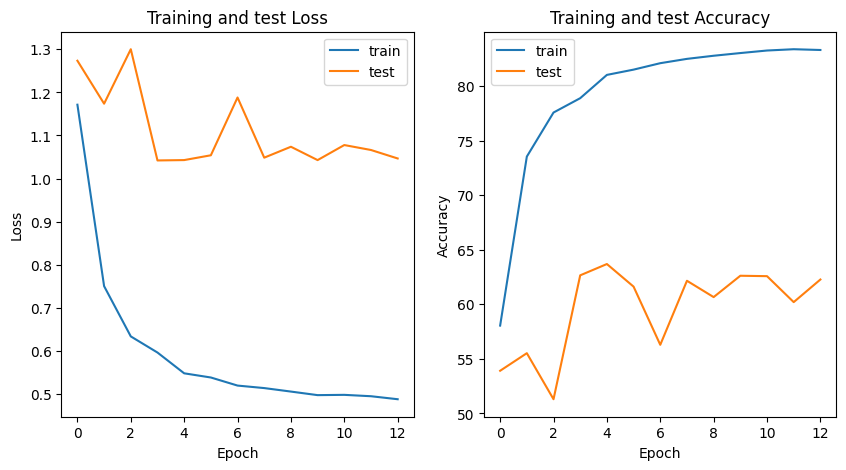

time: 245 ms (started: 2023-05-12 17:44:05 +00:00)


In [21]:
# Plot the training and testing loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and test Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(test_accs, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy')
ax[1].legend()
plt.show()

In [22]:
# Calculate other metrics and the final test accuracy
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate other metrices
n_classes = conf_mat.shape[0]
tprs = []
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    tpr = tp / (tp + fn)
    tprs.append(tpr)
sensitivity = np.mean(tprs)
test_accuracy /= 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 1.0466
Test Accuracy: 0.6228
Sensitivity: 0.5292
ROC-AUC: 0.8398
F1-score: 0.4831
Classification Report:
              precision    recall  f1-score   support

           0     0.3150    0.4494    0.3704        89
           1     0.6095    0.5370    0.5709       311
           2     0.3925    0.6087    0.4773       276
           3     0.2391    0.4074    0.3014        27
           4     0.4856    0.5978    0.5359       450
           5     0.8863    0.6820    0.7708      1349
           6     0.3274    0.4512    0.3795        82
           7     0.4231    0.5000    0.4583        22

    accuracy                         0.6228      2606
   macro avg     0.4598    0.5292    0.4831      2606
weighted avg     0.6841    0.6228    0.6418      2606

time: 25.4 ms (started: 2023-05-12 17:44:05 +00:00)


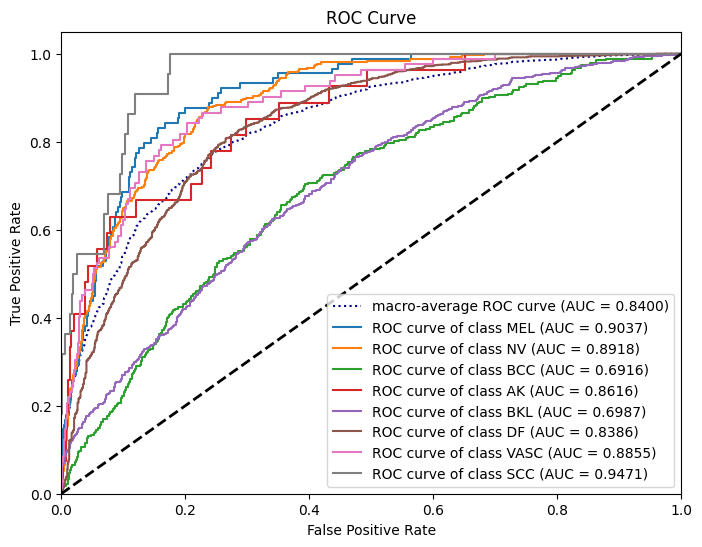

time: 170 ms (started: 2023-05-12 17:44:05 +00:00)


In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

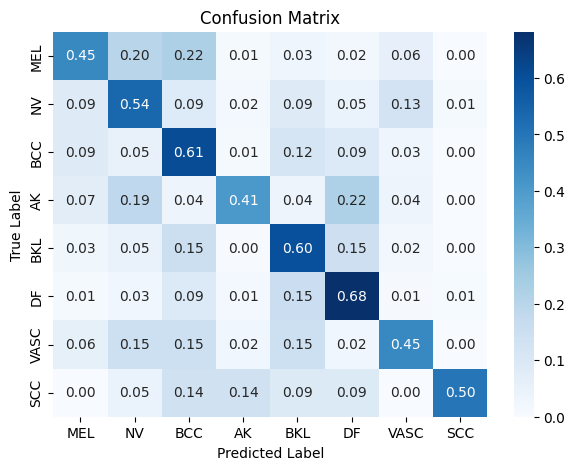

time: 242 ms (started: 2023-05-12 17:44:05 +00:00)


In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()

Reference to the specific libraries that were used in this code

• Ming Yang. "Imbalanced-Dataset-Sampler." 2018. [Online]. Available: https://github.com/ufoym/imbalanced-dataset-sampler. Accessed: April 19, 2023.

• Ross Wightman. "PyTorch Image Models." GitHub repository. 2019. [Online]. Available: https://github.com/rwightman/pytorch-image-models.

• Takuya Akiba, Shotaro Sano, Toshihiko Yanase, Takeru Ohta, and Masanori Koyama. 2019. Optuna: A Next-generation Hyperparameter Optimization Framework. In KDD (arXiv).